In [0]:
try:
  import a_laughlin_fp
except:
#  if running this doesn't work the first time, restart the runtime
  !echo numpy  > requirements.txt
  !echo pandas >> requirements.txt
  !echo spacy  >> requirements.txt
  !echo fn     >> requirements.txt
  !echo funcy  >> requirements.txt
  !echo toolz  >> requirements.txt
  !echo matplotlib  >> requirements.txt
  !echo seaborn  >> requirements.txt
  !echo sklearn  >> requirements.txt
  !echo '-e git+https://github.com/a-laughlin/a-laughlin.git#egg=a_laughlin_py_utils&subdirectory=a_laughlin_py_utils' >> requirements.txt
  !pip install -q -r requirements.txt

In [0]:
import a_laughlin_fp
import pandas as pd;
import numpy as np;
from scipy import linalg
import seaborn as sb
from matplotlib import pyplot as plt
import json
from fn import _ as __,F as partial
# from fn.op import
from a_laughlin_fp import pipe
from a_laughlin_vis import enum_axes

In [0]:
np.set_printoptions(
  suppress=True, # print as floats instead of scientific notation
  precision=2, # Number of digits of precision for floating point output
  threshold=20, # Total number of array elements which trigger summarization rather than full repr 
  floatmode="maxprec_equal", # Print at most precision fractional digits, using same # for all elements in a given array
)
pd.set_option('display.chop_threshold',10)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 1500)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', lambda x: ('%.2f' % x).rstrip('0').rstrip('.'))
pd.set_option('display.colheader_justify','left')
pdcall = lambda *a,**kw:lambda df:__.call(*a,**kw)(df)
pdcallwith=lambda *a,**kw:partial(pdcall,*a,**kw)
dropcols=pdcallwith("drop",axis=1)
auto_diff_periods = lambda df:df.diff(periods=np.prod(list(map(len,df.index.levels[1:]))) or 1)

In [0]:
# if pd is undefined, restart the runtime (menu->Runtime->restart...)

if 'data_raw' not in locals():
  data_raw=pd.read_csv('https://github.com/a-laughlin/data-mining-group/blob/master/data/data.csv?raw=true')
df0=data_raw.copy()

In [0]:
def set_dtypes(df):
  df[['year','month','day']]=df[['year','month','day']].astype(str)
  return df
df1 = set_dtypes(df0)

In [0]:
def rename_columns_that_differ_from_documentation(df):
  return df.rename(columns={
      'time':'reltime',
      'space':'relspace',
      'motion':'relmotion',
      'function':'funct'
  });
df2=rename_columns_that_differ_from_documentation(df1)

In [0]:
def set_index(df):
  df['sub_day']=df.groupby(['year','month','day']).cumcount()+1
  df['date'] = pd.to_datetime(df.apply(lambda r:'-'.join([r.year,r.month,r.day,f"{r.sub_day:02}"]),axis=1))
  return df.set_index(pd.DatetimeIndex(df.date))
df3=set_index(df2)

In [0]:
def remove_unnecessary_columns(df):
  return df.drop([
      'author', # guest authors omitted when making posts_meta.csv
      'year','month','day','date','sub_day', # unnecessary with datetime index
      'Filename','title', # non-categorical non-numeric columns
      'Segment' #always "1"
  ], axis=1)
df4 = remove_unnecessary_columns(df3)
# remove the 4k+ posts with less than 20 words, so their high percentages don't skew the data
df4 = df4.query('WC>20')

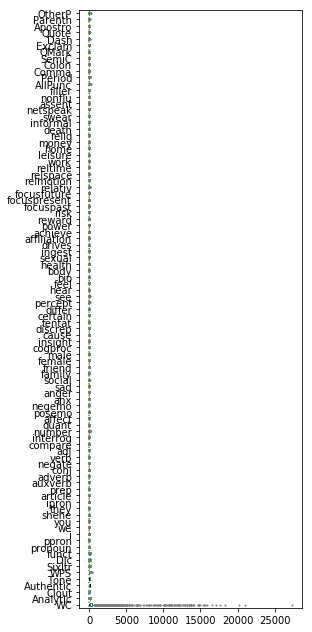

In [159]:
ax = df4.plot.box(figsize=(4,11),vert=False,flierprops=dict(marker='.', markerfacecolor='grey', markersize=4,linestyle='none', markeredgecolor='none'));
ax.vlines([0],ymin=0,ymax=100,linestyles='dotted',colors='grey');

In [0]:
def rescale(df):
  from sklearn.preprocessing import StandardScaler
#   from sklearn.preprocessing import RobustScaler as StandardScaler
  df[df.columns]=StandardScaler().fit_transform(df[df.columns])
  return df
df5 = rescale(df4)

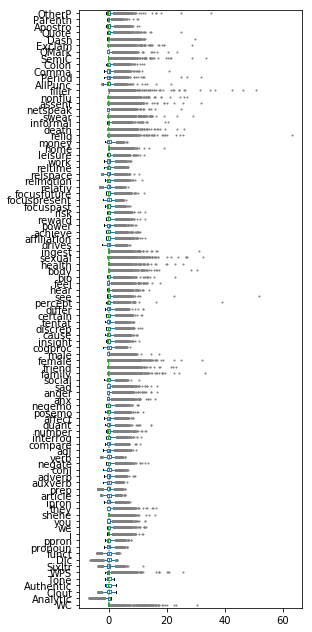

In [162]:
ax = df5.plot.box(figsize=(4,11),vert=False,flierprops=dict(marker='.', markerfacecolor='grey', markersize=4,linestyle='none', markeredgecolor='none'));
ax.vlines([0],ymin=0,ymax=100,linestyles='dotted',colors='grey');
# many skewed-high outliers, but better

In [0]:
def remove_low_volume_years(df):
  return df.query("date>=2003").dropna(axis=0,how='all').dropna(axis=1,how='all')
df6 = remove_low_volume_years(df5)

In [0]:
# separate attributes for analysis
liwc_groups=dict(
  linguistic_summary=['WC','WPS','Sixltr','Dic'],
  linguistic_psych_language=['Analytic','Clout','Authentic','Tone'],#part of linguistic summary in documentation, but different from summary
  linguistic=['funct','pronoun','ppron','i','we','you','shehe','they','ipron','article','prep','auxverb','adverb','conj','negate'],
  other_grammar=['verb','adj','compare','interrog','number','quant'],
  punctuation=['Apostro','Period','Colon','AllPunc','Exclam','QMark','Dash','OtherP','Comma','SemiC','Quote','Parenth'],
  psych_processes=['affect','posemo','negemo','anx','anger','sad'],
  social_processes=['social','family','friend','female','male'],
  cognitive_processes=['cogproc','insight','cause','discrep','tentat','certain','differ'],
  perceptual_processes=['percept','see','hear','feel'],
  bio_processes=['bio','body','health','sexual','ingest'],
  drives=['drives','affiliation','achieve','power','reward','risk'],
  time_orient=['focuspast','focuspresent','focusfuture'],
  relativity=['relativ','relmotion','relspace','reltime'],
  personal_concerns=['work','leisure','home','money','relig','death'],
  informal_language=['informal','swear','netspeak','assent','nonflu','filler']
)
from a_laughlin_fp import flatml
# remove_purely_linguistic_features
groups_to_drop=['linguistic_summary','linguistic','other_grammar','punctuation']
cols_to_drop=flatml(lambda v,k,c:liwc_groups[v],groups_to_drop)
df7=df6.drop(cols_to_drop,axis=1)

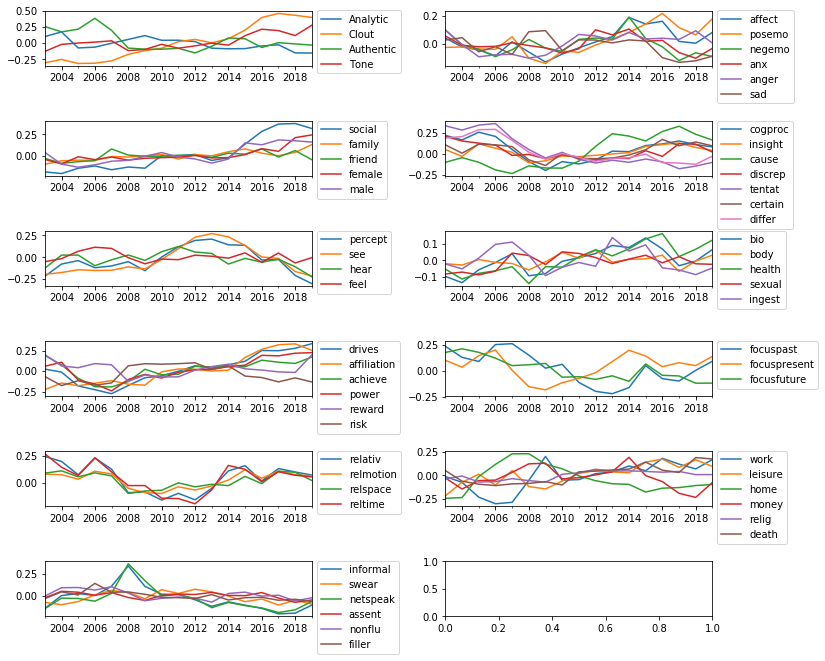

In [165]:
year_means=df7.groupby(pd.Grouper(freq="Y")).mean()
liwc_items=[(k,v) for k,v in liwc_groups.items() if k not in groups_to_drop]
from math import ceil
row_count=ceil(len(liwc_items)/2)
col_count=ceil(len(liwc_items)/row_count)
for (name,cols),(ax,r,c,i) in zip(liwc_items,enum_axes(r=row_count,c=col_count,w=5,h=1.5,subplots_adjust_kw={"wspace":0.5,"hspace":1})):
  year_means[cols].plot(ax=ax)
#   ax.set_ylim(bottom=-0.4,top=0.4)
  ax.xaxis.set_label_text('')
  ax.legend(bbox_to_anchor=(1, 1.1))

In [0]:
def get_correlations_by_year(df):
  cby=df.groupby(pd.Grouper(freq="Y")).corr()
  cby.index.set_names(['year', 'c1'], inplace=True)
  cby.columns.name='c2'
  cby.name="correlations_by_year"
  return cby
correlations_by_year = get_correlations_by_year(df7)

In [0]:
def get_correlations_by_year_flat(cby_df):
  columns_shape=[len(cby_df.iloc[[0]].columns.values)]*2
  upper_triangle_mask=np.triu(np.ones(columns_shape),k=0).astype(np.bool)
  cby_df=cby_df.groupby(level=0).apply(lambda grp:grp.where(upper_triangle_mask))## prevent duplicate correlation values by selecting only upper triangle
  cby_flat=cby_df.stack().to_frame()
  cby_flat.index.set_names(['year', 'c1','c2'], inplace=True)
  cby_flat.columns=['corr']
  cby_flat.loc[:,'corr_diff']=cby_df.diff(periods=np.prod(list(map(len,cby_df.index.levels[1:]))) or 1).stack()
  cby_flat.loc[:,'prev_corr']=cby_flat['corr']-cby_flat['corr_diff']
  cby_flat['posts_count']=0
  cby_flat = cby_flat[['prev_corr','corr','corr_diff']].reset_index()
  return cby_flat
correlations_by_year_flat = get_correlations_by_year_flat(correlations_by_year)

In [0]:
def remove_unhelpful_correlations(cby_flat):
  cby_flat=cby_flat.query("c1!=c2")
  groups_to_filter=['psych_processes', 'social_processes', 'cognitive_processes', 'perceptual_processes', 'bio_processes', 'drives', 'relativity', 'informal_language']
  for grp in groups_to_filter:
    sumname=liwc_groups[grp][0]
    items={k:1 for k in liwc_groups[grp][1:]}
    cby_flat=cby_flat[cby_flat.apply(lambda r:not ((r.c1==sumname and r.c2 in items) or (r.c2==sumname and r.c1 in items)),axis=1)]
  
  return cby_flat

correlations_by_year_flat_trimmed = remove_unhelpful_correlations(correlations_by_year_flat)

In [166]:
display(correlations_by_year_flat_trimmed.set_index(['year','c1','c2']).query('abs(corr)>.7'))

prev_corr  corr  corr_diff
year       c1        c2                                 
2003-12-31 Authentic relativ  nan       0.84    nan     
           sexual    swear    nan       0.73    nan     
2004-12-31 Authentic relativ 0.84       0.84      0     
           Tone      posemo  0.69       0.76   0.07     
2005-12-31 Authentic relativ 0.84       0.79  -0.05     
           Tone      posemo  0.76       0.74  -0.03     
2006-12-31 Authentic relativ 0.79       0.82   0.02     
           Tone      posemo  0.74       0.75   0.01     
2007-12-31 Authentic relativ 0.82       0.77  -0.04     
           Tone      posemo  0.75       0.73  -0.02     
2008-12-31 Authentic relativ 0.77       0.84   0.06     
           Tone      posemo  0.73       0.74   0.01     
2009-12-31 Clout     social  0.69       0.72   0.03     
           Authentic relativ 0.84       0.81  -0.02     
           Tone      posemo  0.74       0.74      0     
2010-12-31 Authentic relativ 0.81       0.81  -0.01     
           Tone      posemo  0.74       0.72  -0.02     
2011-12-31 Clout     social   0.7       0.74   0.04     
           Authentic relativ 0.81       0.82   0.02     
           Tone      posemo  0.72       0.72   0.01     
2012-12-31 Clout     social  0.74       0.73  -0.01     
           Authentic relativ 0.82       0.82  -0.01     
           Tone      posemo  0.72       0.71  -0.01     
2013-12-31 Clout     social  0.73       0.75   0.02     
           Authentic relativ 0.82        0.8  -0.01     
           Tone      posemo  0.71       0.74   0.03     
2014-12-31 Clout     social  0.75       0.75   0.01     
           Authentic relativ  0.8       0.82   0.02     
           Tone      posemo  0.74       0.72  -0.02     
2015-12-31 Clout     social  0.75       0.79   0.04     
           Authentic relativ 0.82       0.77  -0.06     
2016-12-31 Clout     social  0.79        0.8      0     
           Authentic relativ 0.77        0.8   0.03     
           Tone      posemo  0.69       0.71   0.02     
2017-12-31 Clout     social   0.8        0.8      0     
           Authentic relativ  0.8       0.74  -0.05     
           Tone      posemo  0.71       0.74   0.03     
2018-12-31 Clout     social   0.8       0.82   0.02     
           Authentic relativ 0.74       0.72  -0.03     
           Tone      posemo  0.74       0.71  -0.03     
2019-12-31 Clout     social  0.82       0.82      0     
           Authentic relativ 0.72       0.74   0.03     
           Tone      posemo  0.71       0.75   0.04

In [173]:
display(correlations_by_year_flat_trimmed.set_index(['year','c1','c2']).query('abs(corr_diff)>.3'))
# Phases of swearing?
# Phases of family?
# Cycles?

prev_corr  corr  corr_diff
year       c1     c2                                
2004-12-31 sexual swear  0.73        0.14 -0.59     
2006-12-31 family female 0.47        0.04 -0.43     
2007-12-31 family female 0.04        0.38  0.34     
                  nonflu  0.3       -0.01 -0.31     
2010-12-31 sexual swear  0.18        0.49  0.31     
2017-12-31 sexual swear  0.38        0.07 -0.32

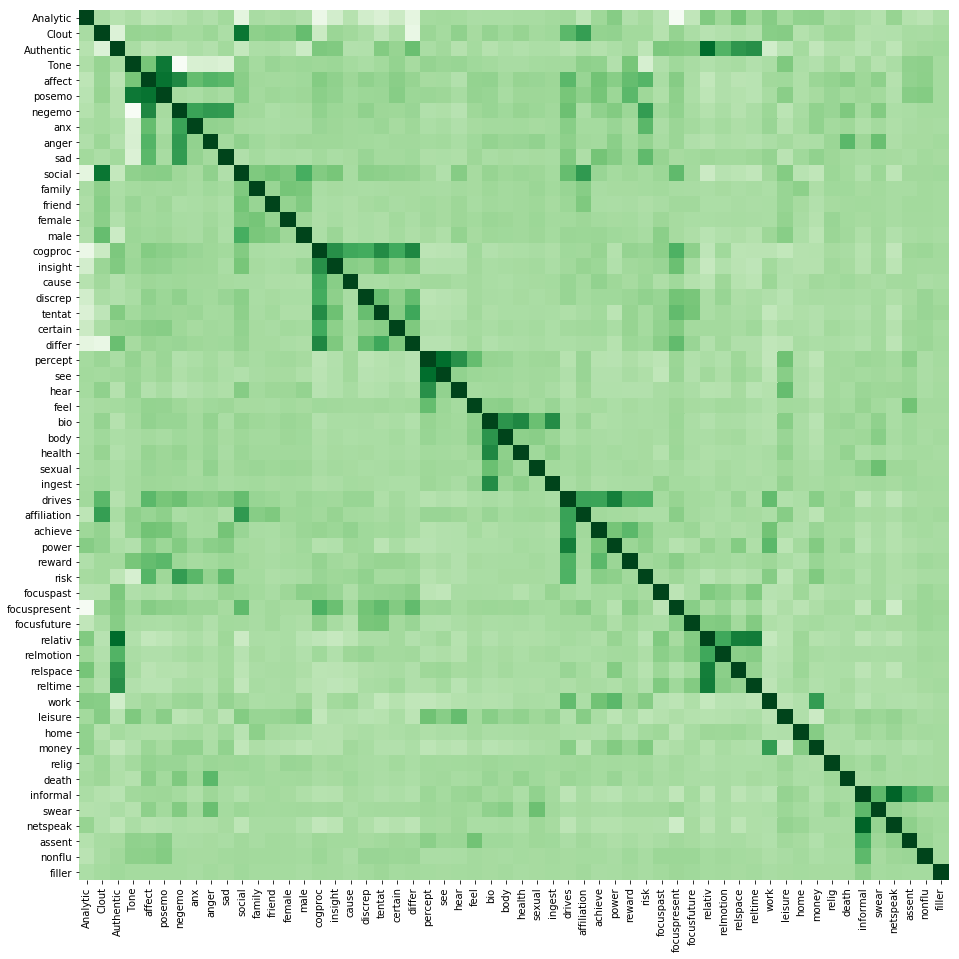

In [180]:
sb.heatmap(df7.corr(),annot=False,fmt='',cbar=False,square=True,cmap="Greens",ax=plt.subplots(1,1,figsize=(16,16))[1]);


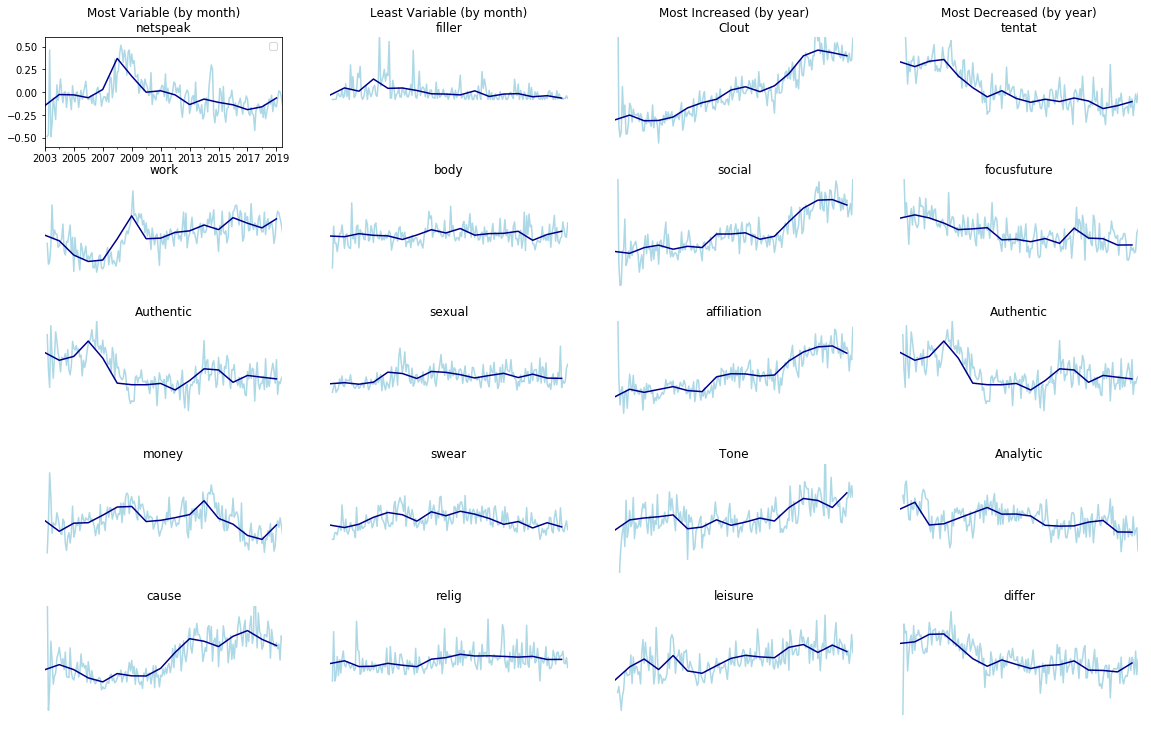

In [129]:
# dff.join(correlations_by_year_flat.to_frame())
# INTERESTING: changes in year over year correlation
# print(len(yeargrps.head(1)))
# which values are most prone to change from year to year?
month_means=df7.groupby(pd.Grouper(freq="M")).mean()
year_means=df7.groupby(pd.Grouper(freq="Y")).mean()
diffs_by_month = month_means.diff(periods=12);
diffs_by_year = year_means.diff(periods=1);
most_variable=diffs_by_month.abs().sum(axis=0).sort_values(ascending=False).index.values
least_variable=diffs_by_month.abs().sum(axis=0).sort_values(ascending=True).index.values
most_increased=diffs_by_year.sum(axis=0).sort_values(ascending=False).index.values
most_decreased=diffs_by_year.sum(axis=0).sort_values(ascending=True).index.values


# # df7[most_prone_to_change[:8]].groupby(df7.index.year).mean().plot(subplots=True,figsize=(5,16));
for ax,r,c,i in enum_axes(r=5,c=4,w=4,h=2,subplots_adjust_kw=dict(hspace=0.3,wspace=0.2)):
  
  ax.set_ylim(bottom=-0.6,top=0.6)
  ax.set_axis_off()
  if c==0:
    if r==0:
      ax.set_axis_on()
#       ax.xaxis.set_visible(False)
      ax.xaxis.set_ticklabels([2003,2019])
      ax.legend({'month':'LightBlue','year':'DarkBlue'})
    title=most_variable[r] if r>=1 else "Most Variable (by month)\n"+most_variable[r]
    month_means[most_variable[r]].plot(ax=ax,title=title,color="LightBlue");
    year_means[most_variable[r]].plot(ax=ax,title=title,color="DarkBlue");
  if c==1:
    title=least_variable[r] if r>=1 else "Least Variable (by month)\n"+least_variable[r]
    month_means[least_variable[r]].plot(ax=ax,title=title,color="LightBlue");
    year_means[least_variable[r]].plot(ax=ax,title=title,color="DarkBlue");
  if c==2:
    title=most_increased[r] if r>=1 else "Most Increased (by year)\n"+most_increased[r]
    month_means[most_increased[r]].plot(ax=ax,title=title,color="LightBlue");
    year_means[most_increased[r]].plot(ax=ax,title=title,color="DarkBlue");
    
  if c==3:
    title=most_decreased[r] if r>=1 else "Most Decreased (by year)\n"+most_decreased[r]
    month_means[most_decreased[r]].plot(ax=ax,title=title,color="LightBlue");
    year_means[most_decreased[r]].plot(ax=ax,title=title,color="DarkBlue");
  ax.xaxis.set_label_text('')
#   ax.xaxis.set_ticklabels([l.strip('20') for l in ax.xaxis.get_ticklabels()])
#   ax.set_xlabel('None')
#   ax.xaxis.set_label('None')

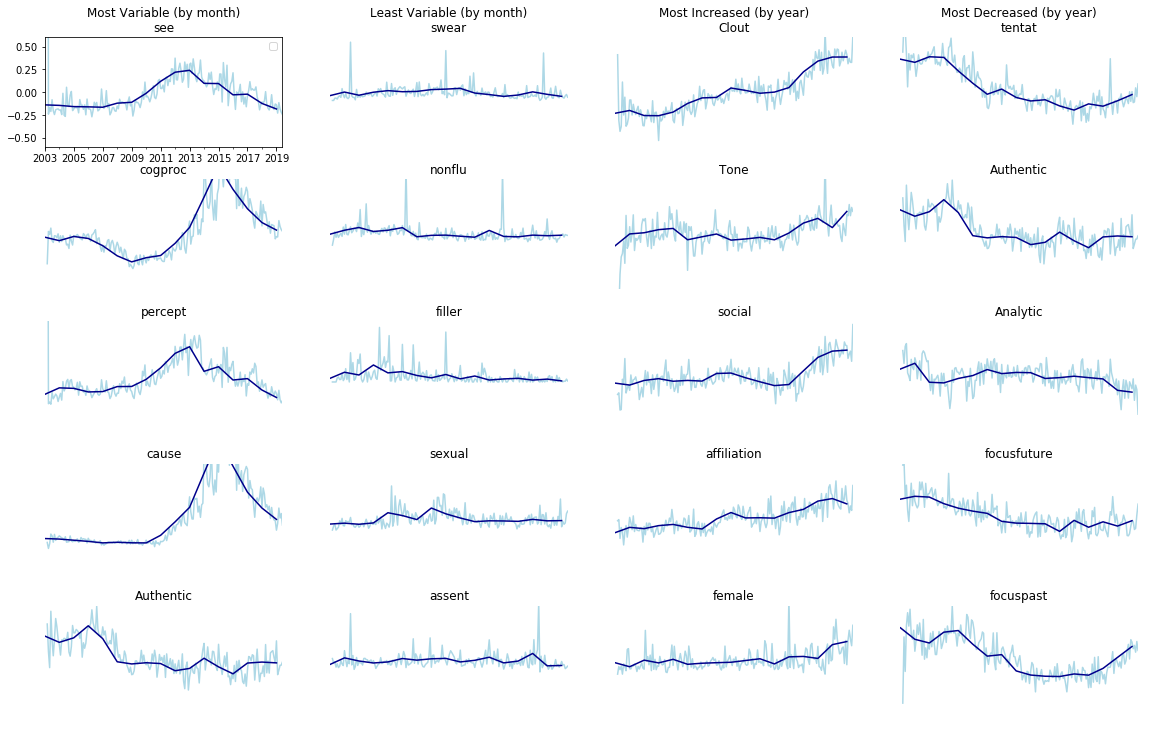

In [118]:
# same plot, run before removing WC<20
# which values are most prone to change from year to year?
month_means=df7.groupby(pd.Grouper(freq="M")).mean()
year_means=df7.groupby(pd.Grouper(freq="Y")).mean()
diffs_by_month = month_means.diff(periods=12);
diffs_by_year = year_means.diff(periods=1);
most_variable=diffs_by_month.abs().sum(axis=0).sort_values(ascending=False).index.values
least_variable=diffs_by_month.abs().sum(axis=0).sort_values(ascending=True).index.values
most_increased=diffs_by_year.sum(axis=0).sort_values(ascending=False).index.values
most_decreased=diffs_by_year.sum(axis=0).sort_values(ascending=True).index.values


# # df7[most_prone_to_change[:8]].groupby(df7.index.year).mean().plot(subplots=True,figsize=(5,16));
for ax,r,c,i in enum_axes(r=5,c=4,w=4,h=2,subplots_adjust_kw=dict(hspace=0.3,wspace=0.2)):
  
  ax.set_ylim(bottom=-0.6,top=0.6)
  ax.set_axis_off()
  if c==0:
    if r==0:
      ax.set_axis_on()
#       ax.xaxis.set_visible(False)
      ax.xaxis.set_ticklabels([2003,2019])
      ax.legend({'month':'LightBlue','year':'DarkBlue'})
    title=most_variable[r] if r>=1 else "Most Variable (by month)\n"+most_variable[r]
    month_means[most_variable[r]].plot(ax=ax,title=title,color="LightBlue");
    year_means[most_variable[r]].plot(ax=ax,title=title,color="DarkBlue");
  if c==1:
    title=least_variable[r] if r>=1 else "Least Variable (by month)\n"+least_variable[r]
    month_means[least_variable[r]].plot(ax=ax,title=title,color="LightBlue");
    year_means[least_variable[r]].plot(ax=ax,title=title,color="DarkBlue");
  if c==2:
    title=most_increased[r] if r>=1 else "Most Increased (by year)\n"+most_increased[r]
    month_means[most_increased[r]].plot(ax=ax,title=title,color="LightBlue");
    year_means[most_increased[r]].plot(ax=ax,title=title,color="DarkBlue");
    
  if c==3:
    title=most_decreased[r] if r>=1 else "Most Decreased (by year)\n"+most_decreased[r]
    month_means[most_decreased[r]].plot(ax=ax,title=title,color="LightBlue");
    year_means[most_decreased[r]].plot(ax=ax,title=title,color="DarkBlue");
  ax.xaxis.set_label_text('')
#   ax.xaxis.set_ticklabels([l.strip('20') for l in ax.xaxis.get_ticklabels()])
#   ax.set_xlabel('None')
#   ax.xaxis.set_label('None')

In [121]:
from sklearn.cluster import OPTICS
from math import inf

optics_clusterer=OPTICS(
  min_samples=5,
  max_eps=np.infty,
  metric='correlation',#’minkowski’,
  p=2,
  metric_params=None,
  cluster_method='xi',
  eps=None,
  xi=0.05,
  predecessor_correction=True,
  min_cluster_size=None,
  algorithm='auto',
  leaf_size=20,
  n_jobs=None
)
optics_clusterer.fit(df7)
# if hasattr(optics_clusterer, 'labels_'):
#   y_pred = optics_clusterer.labels_.astype(np.int)
# else:
#   y_pred = optics_clusterer.predict(X)


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/optics_.py:791: RuntimeWarning:

divide by zero encountered in true_divide



OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=20,
       max_eps=inf, metric='correlation', metric_params=None,
       min_cluster_size=None, min_samples=5, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.05)

In [0]:
optics_labels = optics_clusterer.labels_.astype(np.int)


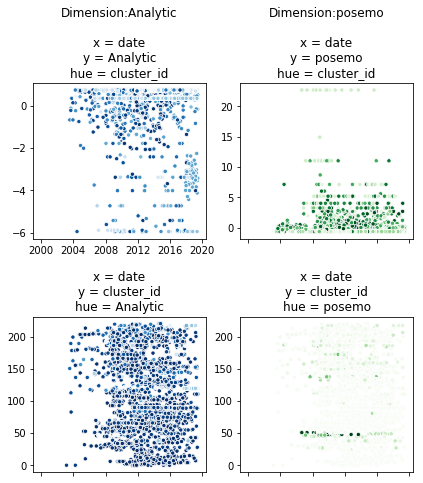

In [216]:
df8=df7.copy().reset_index()
df8['cluster_id']=optics_labels
df8=df8.query('cluster_id>-1') # remove non-clustered rows

for (ax,r,c,i) in enum_axes(r=2,c=2,w=3,h=3,subplots_adjust_kw=dict(hspace=0.5,wspace=0.2)):
#   col=df8.columns[1+i*5]
#   title=''
  if c==0:
    col="Analytic"
    palette="Blues"
  else:
    col="posemo"#cogproc
    palette="Greens"
  if r==0:
    y=col
    hue="cluster_id"
    ax.set_title(f"Dimension:{col}\n\nx = date\ny = {y}\nhue = {hue}")
  else:
    y="cluster_id"
    hue=col
    ax.set_title(f"x = date\ny = {y}\nhue = {hue}")
  
  sb.scatterplot(data=df8,x="date",y=y,hue=hue,ax=ax,legend=None,size=0.5,palette=palette)

  if(c>0 or r>0):
    ax.xaxis.set_ticklabels([])
#     ax.yaxis.set_ticklabels([])
  ax.set_ylabel("");
  ax.set_xlabel('')

In [71]:
import json
labels_to_print=tuple(int(v) for v in optics_clusterer.labels_)
json.dumps(labels_to_print,separators=(',', ':'))

'[-1,-1,-1,-1,-1,-1,-1,-1,46,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,151,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,93,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,157,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,63,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,30,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,183,-1